# NHP

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import scipy as sp
from pathlib import Path
from tqdm.auto import tqdm

from harmony import harmonize
import sys
import matplotlib.pyplot as plt

In [2]:
sys.path.append('/home/gokcen/Code/sctoolkit/')

In [3]:
from sctoolkit.utils import run_spring, dotplot_spring

## Build the matrices

In [88]:
ads = []

for f in tqdm(list(Path('.').glob('*.tab.gz'))):
    if 'metadata' in f.name:
        continue
    exp_type = f.stem.split('_')[1]
    ad = sc.read(f.name).T
    ad.obs['sample_name'] = exp_type
    exp_type = 'WG' if exp_type.startswith('WG') else 'SS2'
    if exp_type == 'SS2':
        ad.obs_names = ad.obs_names.str.replace('-16', '')
    ad.obs_names = ad.obs_names.str.replace('-', '.')
    ad.obs['exp_type'] = exp_type
    
    ads.append(ad)

  0%|          | 0/14 [00:00<?, ?it/s]

In [89]:
ads = sc.concat(ads, join='outer')
ads

AnnData object with n_obs × n_vars = 7430 × 45794
    obs: 'sample_name', 'exp_type'

In [90]:
ads.obs

,sample_name,exp_type
WG17020_A01.W01,WG17020,WG
WG17020_A01.W02,WG17020,WG
WG17020_A01.W03,WG17020,WG
WG17020_A01.W04,WG17020,WG
WG17020_A01.W05,WG17020,WG
...,...,...
SS2.305_P08,SS2-16-305,SS2
SS2.305_P09,SS2-16-305,SS2
SS2.305_P10,SS2-16-305,SS2
SS2.305_P11,SS2-16-305,SS2


In [91]:
pd.crosstab(ads.obs.sample_name, ads.obs.exp_type)

exp_type,SS2,WG
sample_name,,
SS2-16-225,384,0
SS2-16-227,384,0
SS2-16-259,384,0
SS2-16-303,384,0
SS2-16-304,384,0
SS2-16-305,192,0
SS2-16-414,192,0
SS2-16-415,304,0
SS2-16-416,80,0


In [100]:
ss2_meta = pd.read_table('GSE165553_SS2_SmartSeq2_all_metadata.tab.gz').assign(exp_type='SS2')
ss2_meta['Cell.ID'] = ss2_meta['Cell.ID'].str.replace('.16.', '.', regex=False)
wg_meta = pd.read_table('GSE165566_WG_all_metadata.tab.gz').assign(exp_type='WG')
wg_meta.rename(columns={'cell': 'Cell.ID'}, inplace=True)
meta = pd.concat([ss2_meta, wg_meta], axis=0).reset_index(drop=True)
ads.obs = ads.obs.join(meta.set_index('Cell.ID').drop('exp_type', axis=1)).loc[ads.obs_names]

In [101]:
ads.obs

,sample_name,exp_type,Animal.ID,Cell.Identity,Raw.FastQ.name,Plate,Age.y.o,Region,Sex
WG17020_A01.W01,WG17020,WG,NaN,TrpM8high,NaN,WG17020,5,Lumbar,Female
WG17020_A01.W02,WG17020,WG,NaN,NP1,NaN,WG17020,5,Lumbar,Female
WG17020_A01.W03,WG17020,WG,NaN,lowq/nonneuron,NaN,WG17020,5,Lumbar,Female
WG17020_A01.W04,WG17020,WG,NaN,lowq/nonneuron,NaN,WG17020,5,Lumbar,Female
WG17020_A01.W05,WG17020,WG,NaN,NP2,NaN,WG17020,5,Lumbar,Female
...,...,...,...,...,...,...,...,...,...
SS2.305_P08,SS2-16-305,SS2,C09,PEP1,SS2-16-305.414_P08,SS2.305,7,Thoracic,Female
SS2.305_P09,SS2-16-305,SS2,C09,NP1,SS2-16-305.414_P09,SS2.305,7,Thoracic,Female
SS2.305_P10,SS2-16-305,SS2,C09,NP2,SS2-16-305.414_P10,SS2.305,7,Thoracic,Female
SS2.305_P11,SS2-16-305,SS2,C09,A-LTMR,SS2-16-305.414_P11,SS2.305,7,Thoracic,Female


In [102]:
ads

AnnData object with n_obs × n_vars = 7430 × 45794
    obs: 'sample_name', 'exp_type', 'Animal.ID', 'Cell.Identity', 'Raw.FastQ.name', 'Plate', 'Age.y.o', 'Region', 'Sex'

In [104]:
ads = ads[ads.obs['Cell.Identity']!='lowq/nonneuron'].copy()

In [111]:
ads.layers['counts'] = ads.X.copy()

In [112]:
sc.pp.normalize_total(ads, target_sum=10000)
sc.pp.log1p(ads)
ads.layers['scaled'] = ads.X.copy()
sc.pp.scale(ads, max_value=10, layer='scaled')

In [114]:
ads.var

,mean,std
A1BG,0.000839,0.009851
A1CF,0.000115,0.004384
A2M,0.018401,0.084134
A2M-AS1,0.028710,0.068933
A2ML1,0.000475,0.008348
...,...,...
ZYG11A,0.004845,0.025409
ZYG11B,0.124743,0.197567
ZYX,0.136627,0.164041
ZZEF1,0.103683,0.137739


In [118]:
sc.set_figure_params(dpi=100)

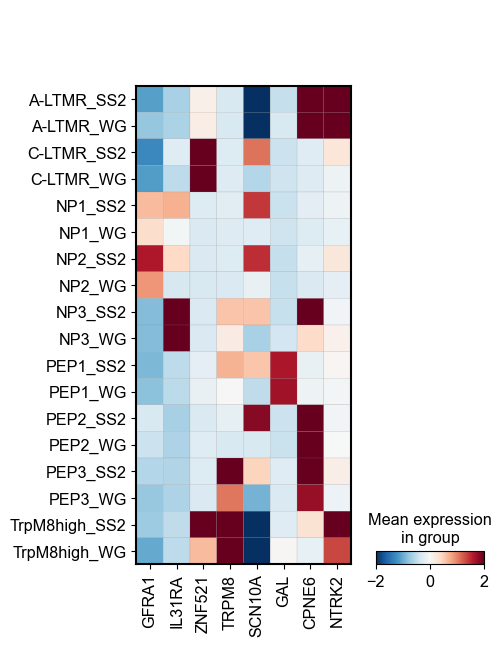

In [123]:
sc.pl.matrixplot(ads, ['GFRA1', 'IL31RA', 'ZNF521', 'TRPM8', 'SCN10A', 'GAL', 'CPNE6', 'NTRK2'], groupby=['Cell.Identity', 'exp_type'], layer='scaled', cmap='RdBu_r', vmax=2, vmin=-2)

In [124]:
ads.write('adata.h5ad')

## WG-only

In [126]:
ads = ads[ads.obs.exp_type == 'WG'].copy()

In [149]:
ads.var

,mean,std,highly_variable,means,dispersions,dispersions_norm
A1BG,0.000643,0.010873,False,7.060978e-04,-1.595321,-1.238620
A1CF,0.000000,1.000000,False,1.000000e-12,NaN,NaN
A2M,0.006639,0.043458,False,7.696163e-03,-1.048845,0.235629
A2M-AS1,0.020571,0.072746,False,2.354424e-02,-1.084541,0.139331
A2ML1,0.000301,0.009234,False,3.488172e-04,-1.084344,0.139861
...,...,...,...,...,...,...
ZYG11A,0.002371,0.023737,False,2.679583e-03,-1.277949,-0.382434
ZYG11B,0.025146,0.078230,False,2.856147e-02,-1.141841,-0.015250
ZYX,0.100610,0.159102,False,1.145901e-01,-1.005472,0.352638
ZZEF1,0.079204,0.142224,False,9.037513e-02,-1.043556,0.249897


In [128]:
ads.layers['scaled'] = ads.X.copy()
sc.pp.scale(ads, max_value=10, layer='scaled')

In [129]:
sc.pp.highly_variable_genes(ads, n_top_genes=2000)
sc.pp.pca(ads)
sc.pp.neighbors(ads)
sc.tl.umap(ads)
sc.tl.leiden(ads)

In [135]:
ads.obsm['X_harmony'] = harmonize(ads.obsm['X_pca'], ads.obs, 'sample_name')
sc.pp.neighbors(ads, use_rep='X_harmony')
sc.tl.umap(ads)
sc.tl.leiden(ads)

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).


In [11]:
ads.var_names[ads.var_names.str.contains('CGR')]

Index(['CGREF1', 'CGRRF1', 'FCGR1A', 'FCGR1B', 'FCGR1CP', 'FCGR2A', 'FCGR2B',
       'FCGR3A', 'FCGRT_loc1', 'FCGRT_loc2', 'GCGR', 'LHCGR'],
      dtype='object')

In [11]:
sc.set_figure_params(dpi=100)

In [13]:
%matplotlib inline

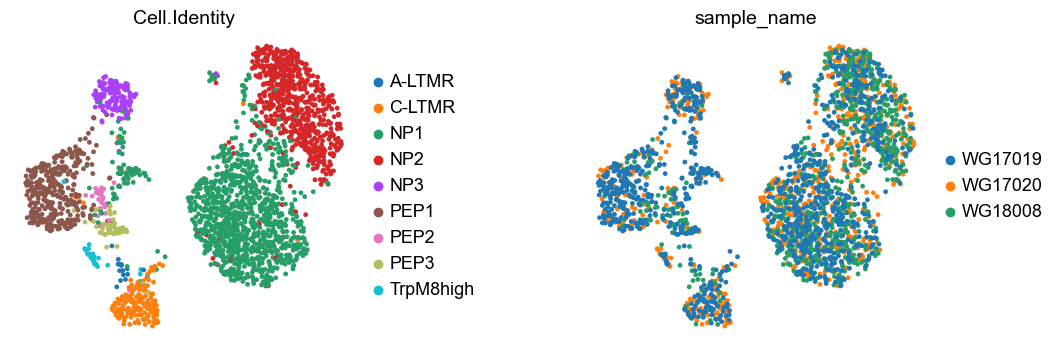

In [15]:
sc.pl.umap(ads, color=['Cell.Identity', 'sample_name'], wspace=0.5, frameon=False, save='-nhp-celltype-samplename.pdf')

In [139]:
ads.write('adata-wgonly-harmonize.h5ad')

In [144]:
run_spring(ads, 'Cell.Identity')

  0%|          | 0/9 [00:00<?, ?it/s]

,names,spring_score,group
0,CBLN2,10.196984,A-LTMR
1,LOC114671312,9.642286,A-LTMR
2,PCDH7,8.876869,A-LTMR
3,SLC10A2,8.382019,A-LTMR
4,NTNG1,8.058200,A-LTMR
...,...,...,...
412141,LOC106992593,NaN,TrpM8high
412142,LOC106992597,NaN,TrpM8high
412143,LOC693973,NaN,TrpM8high
412144,LOC106992568,NaN,TrpM8high


In [7]:
dotplot_spring(ads, 'Cell.Identity', mean_only_expressed=True, standard_scale='var', save='nhp-markers.pdf')

In [5]:
ads = sc.read('adata-wgonly-harmonize.h5ad')
ads

AnnData object with n_obs × n_vars = 2518 × 45794
    obs: 'sample_name', 'exp_type', 'Animal.ID', 'Cell.Identity', 'Raw.FastQ.name', 'Plate', 'Age.y.o', 'Region', 'Sex', 'leiden'
    var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cell.Identity_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'sample_name_colors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scaled'
    obsp: 'connectivities', 'distances'

## Integration

In [ ]:
ad = sc.read('../AtopicDermatitis.h5ad')
ad

In [6]:
ads.obs

,sample_name,exp_type,Animal.ID,Cell.Identity,Raw.FastQ.name,Plate,Age.y.o,Region,Sex,leiden
WG17020_A01.W01,WG17020,WG,NaN,TrpM8high,NaN,WG17020,5,Lumbar,Female,11
WG17020_A01.W02,WG17020,WG,NaN,NP1,NaN,WG17020,5,Lumbar,Female,0
WG17020_A01.W05,WG17020,WG,NaN,NP2,NaN,WG17020,5,Lumbar,Female,1
WG17020_A01.W06,WG17020,WG,NaN,TrpM8high,NaN,WG17020,5,Lumbar,Female,11
WG17020_A01.W09,WG17020,WG,NaN,NP2,NaN,WG17020,5,Lumbar,Female,1
...,...,...,...,...,...,...,...,...,...,...
WG17019_H12.W06,WG17019,WG,NaN,NP1,NaN,WG17019,5,Lumbar,Female,8
WG17019_H12.W12,WG17019,WG,NaN,NP1,NaN,WG17019,5,Lumbar,Female,12
WG17019_H12.W16,WG17019,WG,NaN,C-LTMR,NaN,WG17019,5,Lumbar,Female,6
WG17019_H12.W20,WG17019,WG,NaN,PEP1,NaN,WG17019,5,Lumbar,Female,2


In [7]:
ads.obs['ind_id'] = ads.obs.sample_name
ads.obs['Cell type'] = 'Neurons'
ads.obs['Cell type granular v2'] = ads.obs['Cell.Identity']

In [8]:
ads.X = sp.sparse.csr_matrix(ads.X)
ads.layers['counts'] = sp.sparse.csr_matrix(ads.layers['counts'])

In [19]:
ad_mac = sc.concat([ad, ads], join='outer')
ad_mac

/home/gokcen/.miniconda/lib/python3.8/site-packages/anndata/_core/merge.py:895: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.


AnnData object with n_obs × n_vars = 283036 × 57625
    obs: '10x_cell_calling', 'G2M_score', 'S_score', 'barcode_rank', 'chemistry_10x', 'disease_status', 'empty_drops_FDR', 'ind_id', 'lesional', 'log10_n_genes', 'log10_n_umis', 'mito_cutoff_', 'mt_frac', 'n_counts', 'n_genes', 'n_umis', 'neg_log10_empty_drops_FDR', 'phase', 'predicted_cell_types', 'predicted_sex', 'raw', 'sample_name', 'scrublet', 'scrublet_score', 'sex', 'disease_lesional', 'batch', 'leiden', 'Cell type', 'Cell type granular', 'ind_sample', 'channel', 'barcode', 'subject_id', 'global_disease_assessment', 'ad_family_history', 'sex_clinical', 'childbearing_potential', 'ethnicity_race', 'smoking', 'asthma', 'other_condition', 'systemic_corticosteroids', 'topical_corticosteroids', 'dupilumab', 'dupilumab_indication', 'dupilumab_other_indication', 'location', 'side', 'Disease score (MADAD Immune)', 'Disease score (MADAD Full)', 'Disease score (MADAD Union)', 'Cell type new cornified', 'ind_disease_lesional', 'Cell states

In [21]:
sc.pp.highly_variable_genes(ad_mac, n_top_genes=2000)
sc.pp.pca(ad_mac)

In [22]:
ad_mac.obsm['X_harmony'] = harmonize(ad_mac.obsm['X_pca'], ad_mac.obs, 'ind_id')

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
Reach convergence after 7 iteration(s).


In [ ]:
%%time

#sc.pp.neighbors(ad_mac, use_rep='X_harmony')
sc.pp.neighbors(ad_mac)
sc.tl.umap(ad_mac)
sc.tl.paga(ad_mac, 'Cell type')
sc.pl.paga(ad_mac, threshold=0.1)
sc.tl.umap(ad_mac, init_pos='paga')

In [46]:
ad.obs['Cell type'].cat.categories

Index(['Keratinocytes', 'Cornified keratinocytes', 'Sweat gland',
       'Fibroblasts', 'Pericyte/SMC', 'VEC', 'LEC', 'Melanocytes', 'Schwann',
       'DC', 'Macrophages', 'Neutrophils', 'Mast', 'B cells', 'Plasma',
       'T/NK'],
      dtype='object')

In [56]:
ad_mac.obs['Cell type'].cat.reorder_categories(['Keratinocytes', 'Cornified keratinocytes', 'Sweat gland',
       'Fibroblasts', 'Pericyte/SMC', 'VEC', 'LEC', 'Melanocytes', 'Schwann',
       'DC', 'Macrophages', 'Neutrophils', 'Mast', 'B cells', 'Plasma', 'T/NK', 'Neurons'], inplace=True)

ad_mac.uns['Cell type_colors'] = ad.uns['Cell type_colors'].tolist() + ['darkgray']

In [84]:
ad_mac.obs['Cell states with PathT v2'] = ad_mac.obs['Cell states with PathT v2'].astype(str)
ad_mac.obs['Cell states with PathT v2'].loc[ad_mac.obs['Cell states with PathT v2'].isnull()] = ad_mac.obs['Cell type granular v2'].loc[ad_mac.obs['Cell states with PathT v2'].isnull()]
ad_mac._sanitize()

... storing 'Cell states with PathT v2' as categorical


In [86]:
ad_mac.obs['Cell type granular v2'].cat.reorder_categories(ad.obs['Cell type granular v2'].cat.categories.tolist() + ads.obs['Cell type granular v2'].cat.categories.tolist(), inplace=True)
ad_mac.obs['Cell states with PathT v2'].cat.reorder_categories(ad.obs['Cell states with PathT v2'].cat.categories.tolist() + ads.obs['Cell type granular v2'].cat.categories.tolist(), inplace=True)

In [88]:
#del ad_mac.uns['Cell type granular v2_colors']
#del ad_mac.uns['Cell states with PathT v2_colors']

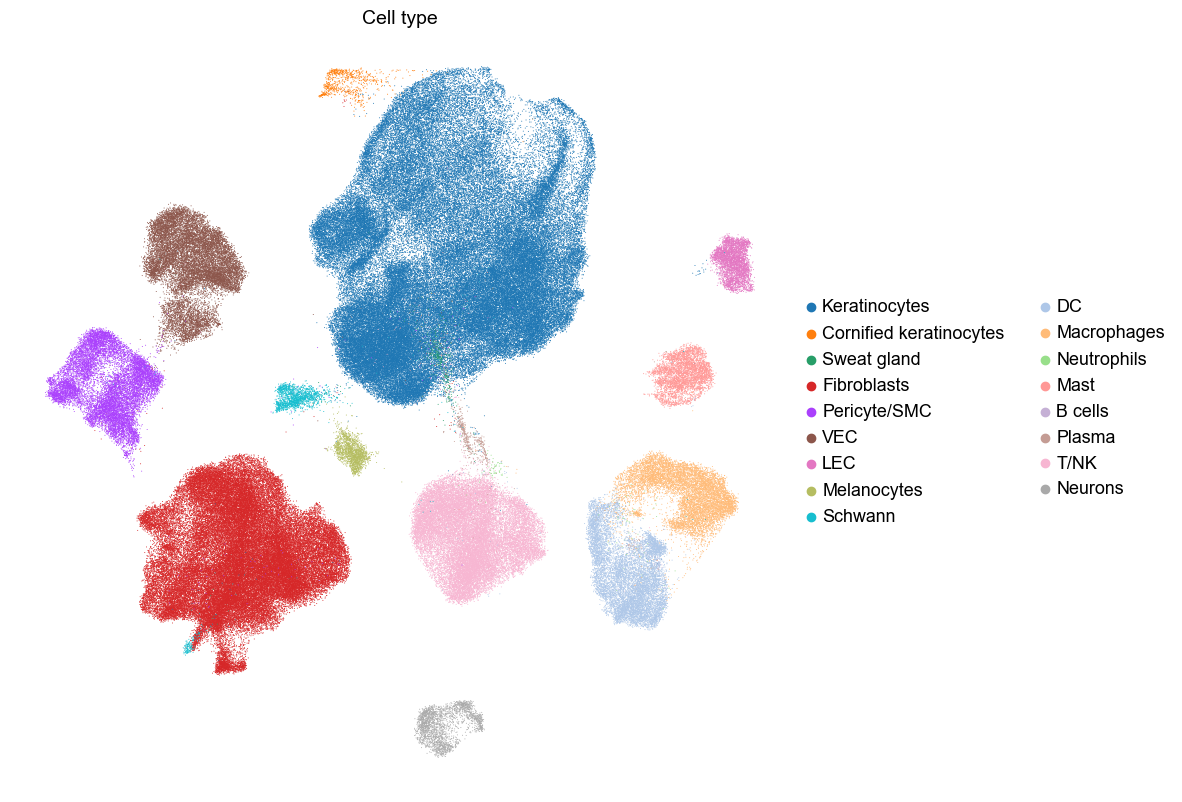

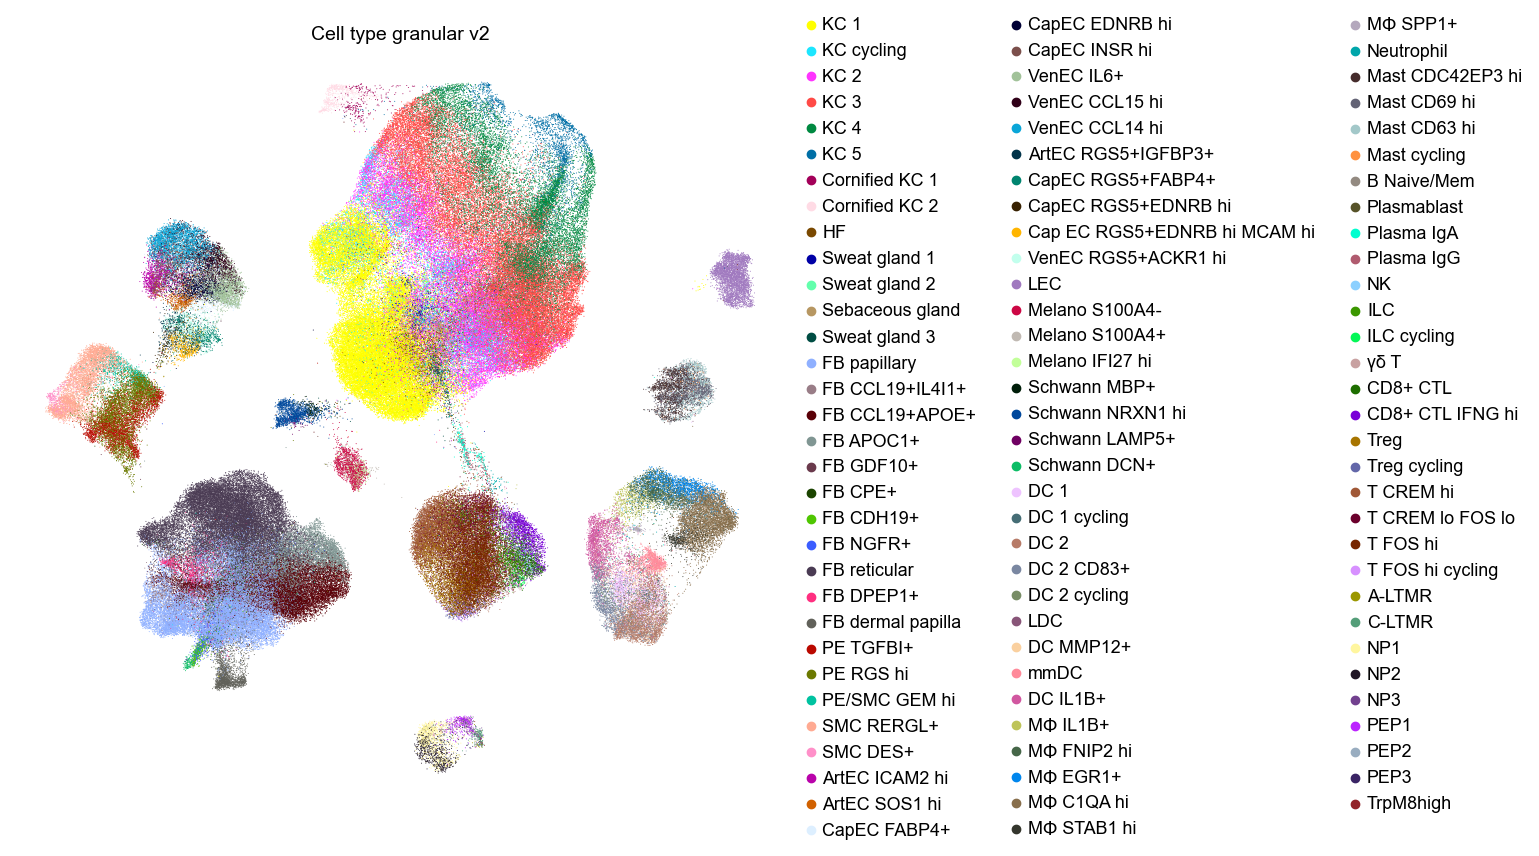

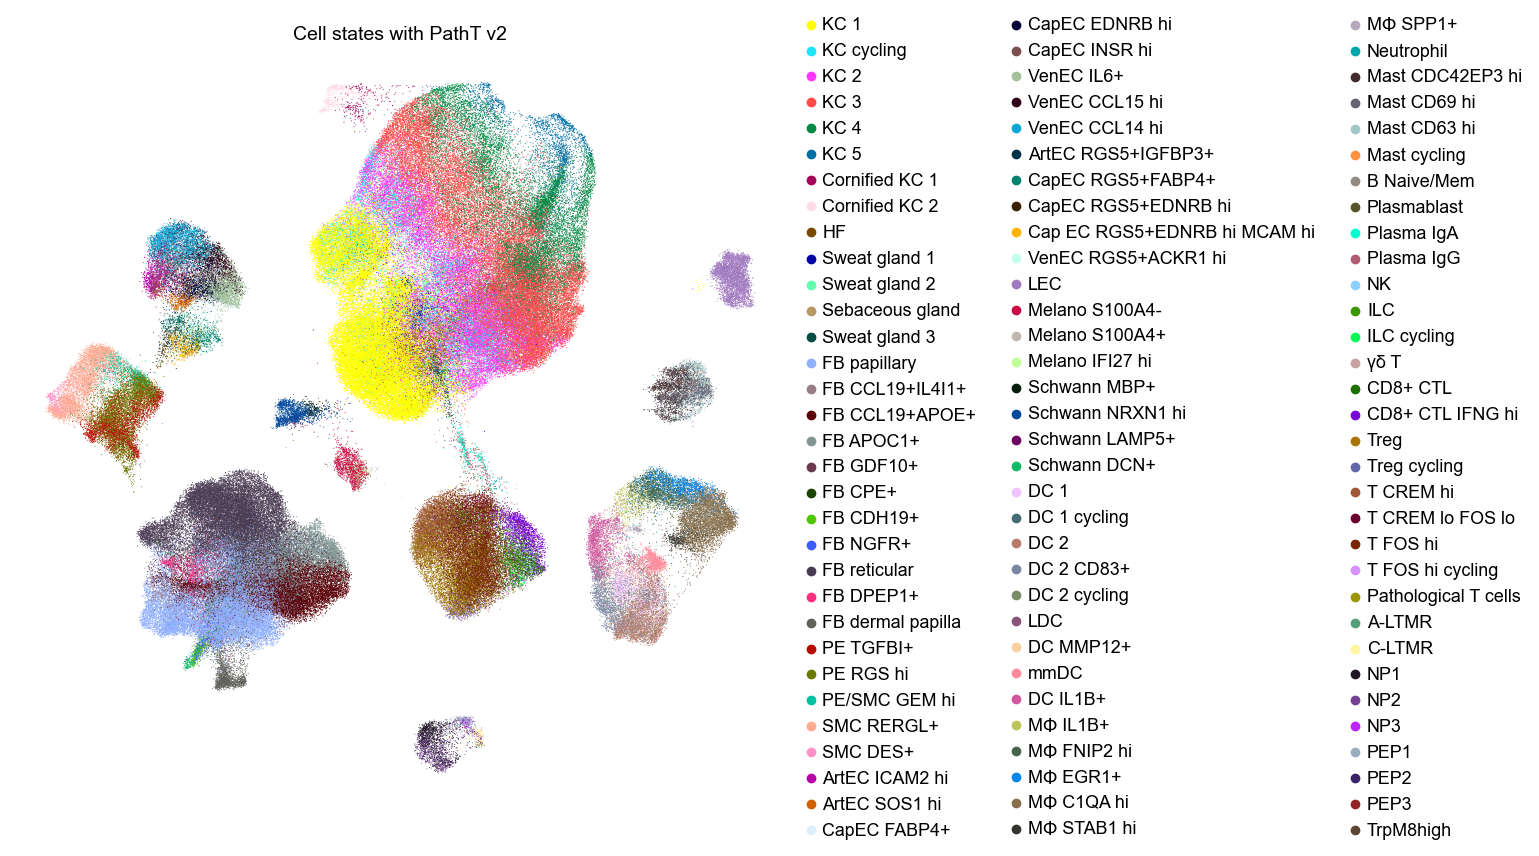

In [89]:
plt.rcParams['figure.figsize'] = (10,10)

sc.pl.umap(ad_mac, color='Cell type', size=2, save='-ad_macaq_celltypes.pdf', frameon=False)
sc.pl.umap(
    ad_mac, color='Cell type granular v2', size=2,
    frameon=False, save='-ad_macaq_celltypes_granular.pdf',
)
sc.pl.umap(
    ad_mac, color='Cell states with PathT v2', size=2,
    frameon=False, save='-ad_macaq_celltypes_granular_withpatht.pdf',
)

plt.rcParams['figure.figsize'] = (4,4)

In [94]:
ad_mac.write('ad_nhp.h5ad')

In [93]:
ad_mac

AnnData object with n_obs × n_vars = 283036 × 57625
    obs: 'G2M_score', 'S_score', 'barcode_rank', 'chemistry_10x', 'disease_status', 'empty_drops_FDR', 'ind_id', 'lesional', 'log10_n_genes', 'log10_n_umis', 'mito_cutoff_', 'mt_frac', 'n_counts', 'n_genes', 'n_umis', 'neg_log10_empty_drops_FDR', 'phase', 'predicted_cell_types', 'predicted_sex', 'sample_name', 'scrublet_score', 'sex', 'disease_lesional', 'batch', 'leiden', 'Cell type', 'Cell type granular', 'ind_sample', 'channel', 'barcode', 'subject_id', 'global_disease_assessment', 'ad_family_history', 'sex_clinical', 'childbearing_potential', 'ethnicity_race', 'smoking', 'asthma', 'other_condition', 'systemic_corticosteroids', 'topical_corticosteroids', 'dupilumab', 'dupilumab_indication', 'dupilumab_other_indication', 'location', 'side', 'Disease score (MADAD Immune)', 'Disease score (MADAD Full)', 'Disease score (MADAD Union)', 'Cell type new cornified', 'ind_disease_lesional', 'Cell states with PathT', 'Cell type granular v2', 